--- 

# 2. Border

Optimized compactness extraction - faster code

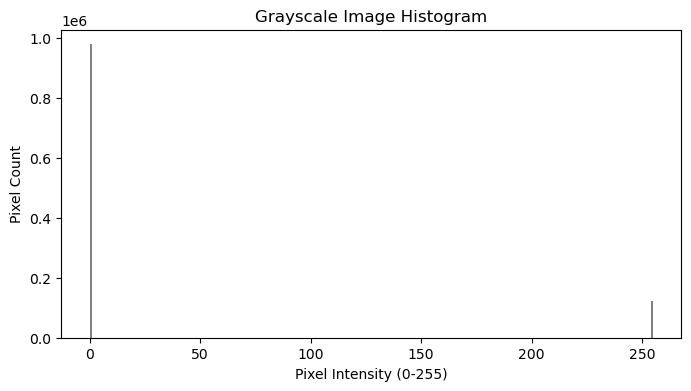

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Load image as grayscale
file_im = './data/lesion_masks/PAT_8_15_820_mask.png'
im = cv2.imread(file_im, cv2.IMREAD_GRAYSCALE)

# Plot histogram
plt.figure(figsize=(8, 4))
plt.hist(im.flatten(), bins=256, color='gray')
plt.xlabel('Pixel Intensity (0-255)')
plt.ylabel('Pixel Count')
plt.title('Grayscale Image Histogram')
plt.show()

Compactness already tells how irregular the border of the image is, so no need to process the value further.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#Boarder extraction feature using classical compactness formula, but optimized courner detection techniques
def B_compactness(m):
    #converting image to gray scale (remove before working with classifier) -> should be binary
    mask = cv2.imread(m, cv2.IMREAD_GRAYSCALE)
    #function used to find all detected borders, shapes
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #extracting the largest boarder, furthest from the center with largest area
    largest_contour = max(contours, key=cv2.contourArea)
    #computes euclidean distancesfor perimeter determination, close = True for closed countour shape
    perimeter = cv2.arcLength(largest_contour, closed=True)
    #calculates area using Green’s Theorem treating contour as a polygon
    area = cv2.contourArea(largest_contour)
    #calculating compactness using classical formula
    compactness = (4 * np.pi * area) / (perimeter ** 2)

    return compactness

The code that we were provided by last year students - slow running time

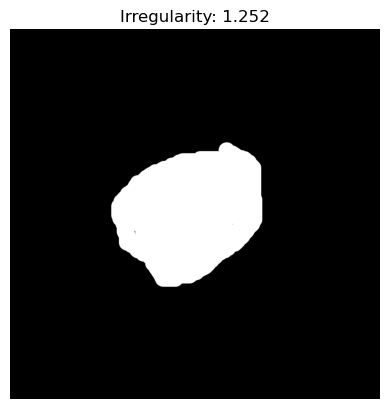

In [78]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('./data/lesion_masks/PAT_8_15_820_mask.png', cv2.IMREAD_GRAYSCALE)

def measure_streaks(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #returns a list of pixels that are in the border (edge)

    lesion_area = cv2.contourArea(contours[0])
    border_perimeter = cv2.arcLength(contours[0], True) 
    if lesion_area == 0:
        irregularity = 0
    else:
        irregularity = (border_perimeter ** 2) / (4 * np.pi * lesion_area)

    return irregularity

result = measure_streaks(img)
plt.imshow(img, cmap="gray")
plt.title(f"Irregularity: {result:.3f}")
plt.axis('off')  # Optional: hides the axes
plt.show()

This number makes sense, since it is a bit irregular because perimeter exceeds area, lets try more examples and see their values

# Load your DataFrame
data = pd.read_csv('feature_extraction_set.csv')

# Folder with lesion masks
mask_dir = './data/lesion_masks/'

# Initialize empty column
data['compactness'] = np.nan

# Efficient iteration
for idx, row in data.iterrows():
    base_name = row['img_base']
    mask_path = os.path.join(mask_dir, f"{base_name}_mask.png")

    if os.path.isfile(mask_path):
        try:
            score = B_compactness(mask_path)
            data.at[idx, 'compactness'] = score
        except Exception as e:
            print(f"Error at {mask_path}: {e}")
    else:
        print(f"Missing mask: {mask_path}")

In [121]:
import pandas as pd
import numpy as np
import os
import numpy as np
import cv2
from skimage import morphology

def get_compactness(mask_path):

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    # Convert to binary boolean mask
    mask = mask > 0  # Now it's a boolean array, as required

    area = np.sum(mask)
    if area == 0:
        return 0

    struct_el = morphology.disk(3)

    try:
        mask_eroded = morphology.binary_erosion(mask, struct_el)
        perimeter = np.sum(mask & ~mask_eroded)  # Boolean logic
    except Exception as e:
        print(f"Error processing {mask_path}: {e}")
        return 0

    if perimeter == 0:
        return 0

    return round((4 * np.pi * area) / (perimeter ** 2), 4)

In [194]:
# Load your DataFrame
data = pd.read_csv('feature_extraction_set.csv')

# Folder with lesion masks
mask_dir = './data/lesion_masks/'

# Initialize empty column
data['compactness'] = np.nan

# Efficient iteration
for idx, row in data.iterrows():
    base_name = row['img_base']
    mask_path = os.path.join(mask_dir, f"{base_name}_mask.png")

    if os.path.isfile(mask_path):
        try:
            score = B_compactness(mask_path)
            data.at[idx, 'compactness'] = score
        except Exception as e:
            print(f"Error at {mask_path}: {e}")
    else:
        print(f"Missing mask: {mask_path}")

In [189]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data['compactness_std'] = scaler.fit_transform(data[['compactness']])

In [196]:
data

,diagnostic,img_id,img_base,compactness
0,1,PAT_106_159_325.png,PAT_106_159_325,0.694909
1,0,PAT_107_160_609.png,PAT_107_160_609,0.827416
2,0,PAT_289_1399_481.png,PAT_289_1399_481,0.890640
3,0,PAT_26_37_865.png,PAT_26_37_865,0.825954
4,1,PAT_98_152_562.png,PAT_98_152_562,0.795918
...,...,...,...,...
115,1,PAT_131_197_260.png,PAT_131_197_260,0.776006
116,1,PAT_135_202_593.png,PAT_135_202_593,0.700059
117,1,PAT_90_138_605.png,PAT_90_138_605,0.781715
118,1,PAT_160_249_76.png,PAT_160_249_76,0.838848


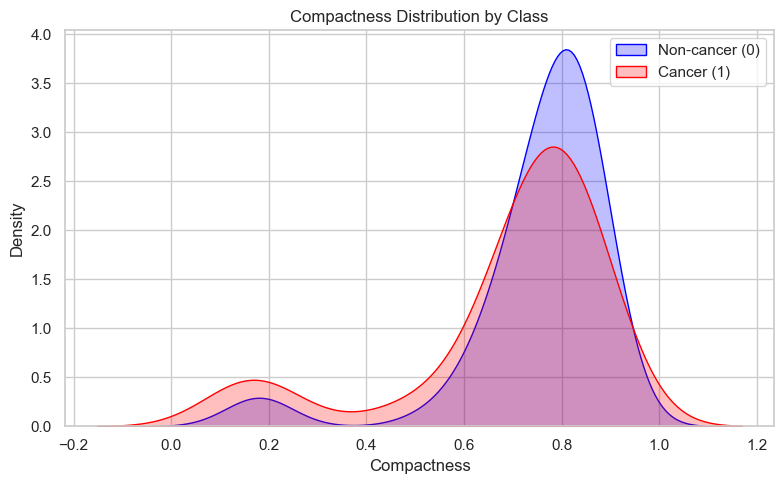

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is called 'data' with columns 'compactness' and 'diagnostic'
plt.figure(figsize=(8, 5))
sns.kdeplot(data=data[data['diagnostic'] == 0], x='compactness', label='Non-cancer (0)', fill=True, color='blue')
sns.kdeplot(data=data[data['diagnostic'] == 1], x='compactness', label='Cancer (1)', fill=True, color='red')

plt.title('Compactness Distribution by Class')
plt.xlabel('Compactness')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

# 1. Asymmetry

In [198]:
import cv2
import numpy as np
from math import floor, ceil
from skimage.transform import rotate

#Main call -> mean_asymmetry

"""Calculating asymetry score by rotating image 4 times(90 degrees) and calculating
asymetry each time"""

def cut_mask(mask):
    """Removing big part of black background to avoid misleading 
    asymetry and computational cost"""
    rows = np.any(mask, axis=1) #rows that have white pixels
    cols = np.any(mask, axis=0) #columns that have white pixels

    row_min, row_max = np.where(rows)[0][[0, -1]] #indexes of white rows
    col_min, col_max = np.where(cols)[0][[0, -1]] #indexes of white columns

    return mask[row_min:row_max+1, col_min:col_max+1] #bounding box of the lesion

def find_midpoint(image):
    """Mid point detection of the lesion, where image is grayscale mask"""
    return image.shape[0] // 2, image.shape[1] // 2 #middle row, middle column (x,y)

def asymmetry(mask):
    """Measuring shape asymetry of the mask"""
    row_mid, col_mid = find_midpoint(mask) #middle point

    #splitting the mask into 4 halves
    upper = mask[:row_mid, :]
    lower = mask[-row_mid:, :]
    left = mask[:, :col_mid]
    right = mask[:, -col_mid:]

    #flipping bottom and right half
    flipped_lower = np.flipud(lower) #flip up
    flipped_right = np.fliplr(right) #flip left

    #the following codes are used to ensure that when halves are compared,
    #the arrays have the same sizes for np.logical_xor() to work
    hmin = min(upper.shape[0], flipped_lower.shape[0]) #picks the smallest number of rows
    vmin = min(left.shape[1], flipped_right.shape[1]) #picks the smallest number of columns

    #counting mismatched pixels
    hori_xor = np.logical_xor(upper[:hmin, :], flipped_lower[:hmin, :])
    vert_xor = np.logical_xor(left[:, :vmin], flipped_right[:, :vmin])

    #calculating the area -> sum of the white pixels
    total = np.sum(mask)
    if total == 0: #if mask is black to avoid division by zero error
        return np.nan

    #calculating the asymetry score (0 perfect symetry, 1 very asymetric)
    score = (np.sum(hori_xor) + np.sum(vert_xor)) / (2 * total) 
    #total mismatch standardized by total pixels in lesion tp get score 0 to 1
    return round(score, 4)

def rotation_asymmetry(mask, n=4):
    """Rotating the picture n times and getting asymetry 
    scores for every rotation"""
    asymmetry_scores = []

    for i in range(n):
        deg = 360 * i / n
    #optimization, if the angle is multiple of 90 use np.rot90 which is faster than rotate function
        if deg % 90 == 0:
            k = int(deg // 90)
            rotated = np.rot90(mask, k)
        else:
            rotated = rotate(mask, deg, preserve_range=True, order=0).astype(np.uint8)

        cropped = cut_mask(rotated > 0)#creating a binary bounded lesion, avoiding interpolation artifacts
        score = asymmetry(cropped)
        asymmetry_scores.append(score)

    return asymmetry_scores

def mean_asymmetry(path, rotations=4):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    if mask is None: #check if mask exists
        return np.nan
    mask = (mask > 0).astype(np.uint8) #binarizing because mask is in gray scale

    scores = rotation_asymmetry(mask, rotations)
    return round(np.nanmean(scores), 4)



In [199]:
# Folder with lesion masks
mask_dir = './data/lesion_masks/'

# Initialize empty column
data['asymmetry'] = np.nan

# Efficient iteration
for idx, row in data.iterrows():
    base_name = row['img_base']
    mask_path = os.path.join(mask_dir, f"{base_name}_mask.png")

    if os.path.isfile(mask_path):
        try:
            score = mean_asymmetry(mask_path)
            data.at[idx, 'asymmetry'] = score
        except Exception as e:
            print(f"Error at {mask_path}: {e}")
    else:
        print(f"Missing mask: {mask_path}")

In [200]:
data

,diagnostic,img_id,img_base,compactness,asymmetry
0,1,PAT_106_159_325.png,PAT_106_159_325,0.694909,0.1232
1,0,PAT_107_160_609.png,PAT_107_160_609,0.827416,0.1024
2,0,PAT_289_1399_481.png,PAT_289_1399_481,0.890640,0.0380
3,0,PAT_26_37_865.png,PAT_26_37_865,0.825954,0.0887
4,1,PAT_98_152_562.png,PAT_98_152_562,0.795918,0.0646
...,...,...,...,...,...
115,1,PAT_131_197_260.png,PAT_131_197_260,0.776006,0.0900
116,1,PAT_135_202_593.png,PAT_135_202_593,0.700059,0.1231
117,1,PAT_90_138_605.png,PAT_90_138_605,0.781715,0.0981
118,1,PAT_160_249_76.png,PAT_160_249_76,0.838848,0.1156


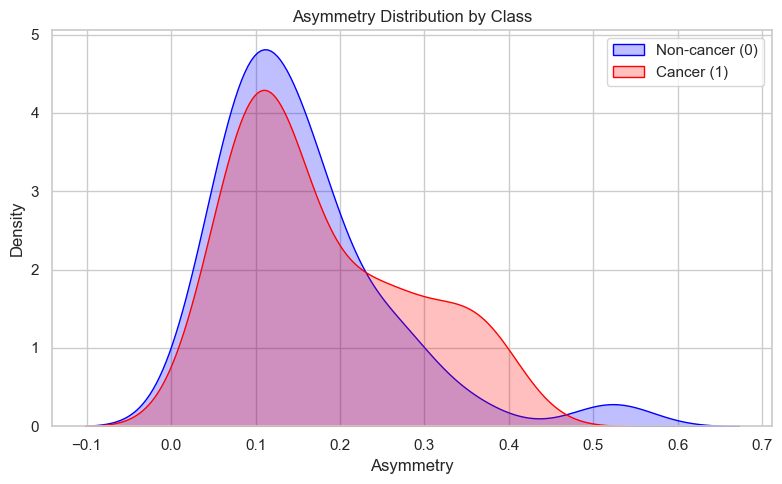

In [201]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is called 'data' with columns 'compactness' and 'diagnostic'
plt.figure(figsize=(8, 5))
sns.kdeplot(data=data[data['diagnostic'] == 0], x='asymmetry', label='Non-cancer (0)', fill=True, color='blue')
sns.kdeplot(data=data[data['diagnostic'] == 1], x='asymmetry', label='Cancer (1)', fill=True, color='red')

plt.title('Asymmetry Distribution by Class')
plt.xlabel('Asymmetry')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

---
# 3. Color

In [ ]:
import pandas as pd
import numpy as np
import os
import numpy as np
import cv2
from util.feature_C import slic_segmentation, get_color_vector

# Load DataFrame
data = pd.read_csv('feature_extraction_set.csv')

# Folder with lesion masks
img_dir = './data/imgs_part_1/'
mask_dir = './data/lesion_masks/'
downsizing_factor = 0.4

# Initialize empty column
data['color'] = None

# Efficient iteration
for idx, row in data.iterrows():
    img_path = os.path.join(img_dir, f"{row['img_id']}")
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (int(img.shape[1] * downsizing_factor), int(img.shape[0] * downsizing_factor)), interpolation=cv2.INTER_AREA) #key step to improve running time

    mask_path = os.path.join(mask_dir, f"{row['img_base']}_mask.png")
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (int(mask.shape[1] * downsizing_factor), int(mask.shape[0] * downsizing_factor)), interpolation=cv2.INTER_NEAREST) #key step to improve running time

    vector = slic_segmentation(img, mask, n_segments=25, compactness=0.5)
    data.at[idx, 'color'] = True

data

,diagnostic,img_id,img_base,color
0,1,PAT_106_159_325.png,PAT_106_159_325,True
1,0,PAT_107_160_609.png,PAT_107_160_609,True
2,0,PAT_289_1399_481.png,PAT_289_1399_481,True
3,0,PAT_26_37_865.png,PAT_26_37_865,True
4,1,PAT_98_152_562.png,PAT_98_152_562,True
...,...,...,...,...
115,1,PAT_131_197_260.png,PAT_131_197_260,True
116,1,PAT_135_202_593.png,PAT_135_202_593,True
117,1,PAT_90_138_605.png,PAT_90_138_605,True
118,1,PAT_160_249_76.png,PAT_160_249_76,True


We see that the running time of slic_algorithm with previous downsampling is pretty good, an average of 17 seconds for 120 images which gives an average of 0.14 s per image. We now need to perform the whole vector extraction to see whats the running time, and evaluate correctness.

In [57]:
import pandas as pd
import numpy as np
import os
import numpy as np
import cv2
from util.feature_C import get_color_vector

# Load DataFrame
data = pd.read_csv('feature_extraction_set.csv')

# Folder with lesion masks
img_dir = './data/imgs_part_1/'
mask_dir = './data/lesion_masks/'

# Initialize empty column
data['color'] = None

# Efficient iteration
for idx, row in data.iterrows():
    img_path = os.path.join(img_dir, f"{row['img_id']}")
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask_path = os.path.join(mask_dir, f"{row['img_base']}_mask.png")
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    vector = get_color_vector(img, mask, n_segments=30, compactness=0.1, kasmi_threshold=0.4)
    data.at[idx, 'color'] = vector

data

,diagnostic,img_id,img_base,color
0,1,PAT_106_159_325.png,PAT_106_159_325,"[0.0, 0.0, 0.3076923076923077, 0.4615384615384..."
1,0,PAT_107_160_609.png,PAT_107_160_609,"[0.05555555555555555, 0.0, 0.0, 0.0, 0.0, 0.94..."
2,0,PAT_289_1399_481.png,PAT_289_1399_481,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,0,PAT_26_37_865.png,PAT_26_37_865,"[0.0, 0.15384615384615385, 0.07692307692307693..."
4,1,PAT_98_152_562.png,PAT_98_152_562,"[0.2727272727272727, 0.0, 0.0, 0.0, 0.0, 0.727..."
...,...,...,...,...
115,1,PAT_131_197_260.png,PAT_131_197_260,"[0.0, 0.0, 0.0, 0.75, 0.0, 0.25]"
116,1,PAT_135_202_593.png,PAT_135_202_593,"[0.14285714285714285, 0.0, 0.0, 0.142857142857..."
117,1,PAT_90_138_605.png,PAT_90_138_605,"[0.0, 0.0, 0.3333333333333333, 0.3333333333333..."
118,1,PAT_160_249_76.png,PAT_160_249_76,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"


Randomly pick images and see if the numbers make sense 

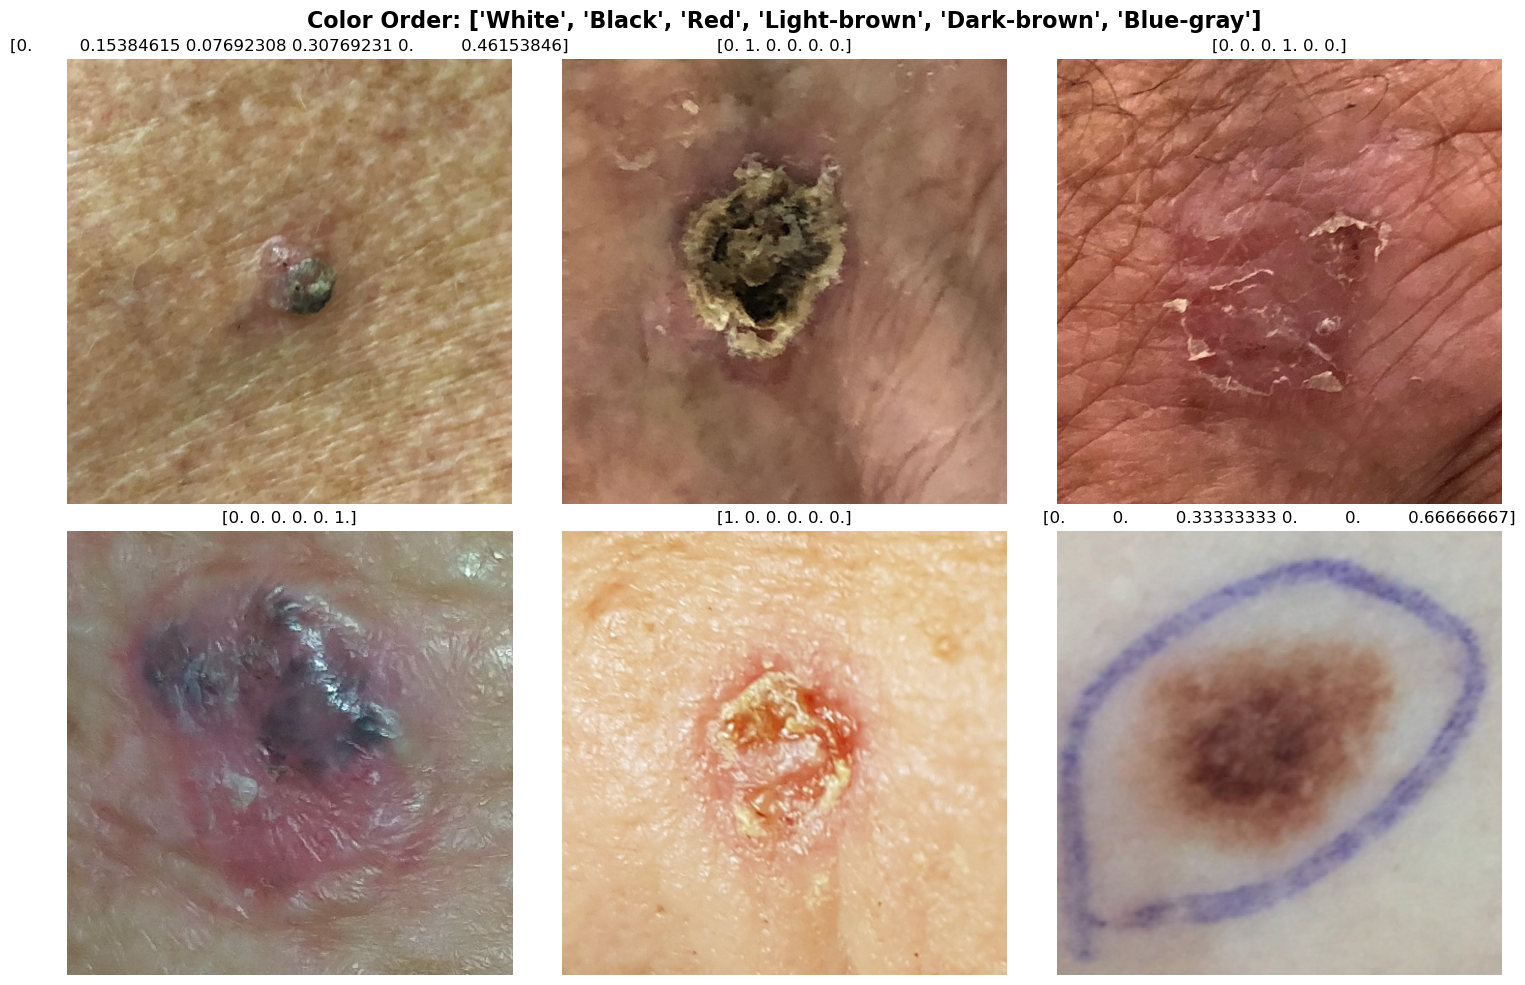

In [58]:
#evaluating if the values in color vector make sense through visual inspection

import matplotlib.pyplot as plt
import cv2
import numpy as np

# Randomly select 6 positions
img_dir = './data/imgs_part_1/'
random_samples = data.sample(6)

# Set up the figure
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Color Order: ['White', 'Black', 'Red', 'Light-brown', 'Dark-brown', 'Blue-gray']", fontsize=16, fontweight='bold')
axes = axes.flatten()

# Display each image with vector as title
for ax, (_, row) in zip(axes, random_samples.iterrows()):
    img_path = os.path.join(img_dir, f"{row['img_id']}")
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax.imshow(img_rgb)
    ax.set_title(f"{row['color']}")
    ax.axis('off')

plt.tight_layout()
plt.show()


After many random visual inspections, the algorithm throws reasonable numbers and with a very good running time!!!
Approximately 25 s to process 120 images, which gives an average of 0.2083 seconds per image

In [59]:
# Define color labels in Kasmi order
color_labels = ['white', 'black', 'red', 'light_brown', 'dark_brown', 'blue_gray']

# Convert the 'color' column into a DataFrame with six separate columns
color_df = pd.DataFrame(data['color'].tolist(), columns=color_labels)

# Concatenate this back with the original DataFrame
data_better = pd.concat([data.drop(columns=['color']), color_df], axis=1)
data_better

,diagnostic,img_id,img_base,white,black,red,light_brown,dark_brown,blue_gray
0,1,PAT_106_159_325.png,PAT_106_159_325,0.000000,0.000000,0.307692,0.461538,0.230769,0.000000
1,0,PAT_107_160_609.png,PAT_107_160_609,0.055556,0.000000,0.000000,0.000000,0.000000,0.944444
2,0,PAT_289_1399_481.png,PAT_289_1399_481,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0,PAT_26_37_865.png,PAT_26_37_865,0.000000,0.153846,0.076923,0.307692,0.000000,0.461538
4,1,PAT_98_152_562.png,PAT_98_152_562,0.272727,0.000000,0.000000,0.000000,0.000000,0.727273
...,...,...,...,...,...,...,...,...,...
115,1,PAT_131_197_260.png,PAT_131_197_260,0.000000,0.000000,0.000000,0.750000,0.000000,0.250000
116,1,PAT_135_202_593.png,PAT_135_202_593,0.142857,0.000000,0.000000,0.142857,0.000000,0.714286
117,1,PAT_90_138_605.png,PAT_90_138_605,0.000000,0.000000,0.333333,0.333333,0.333333,0.000000
118,1,PAT_160_249_76.png,PAT_160_249_76,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000


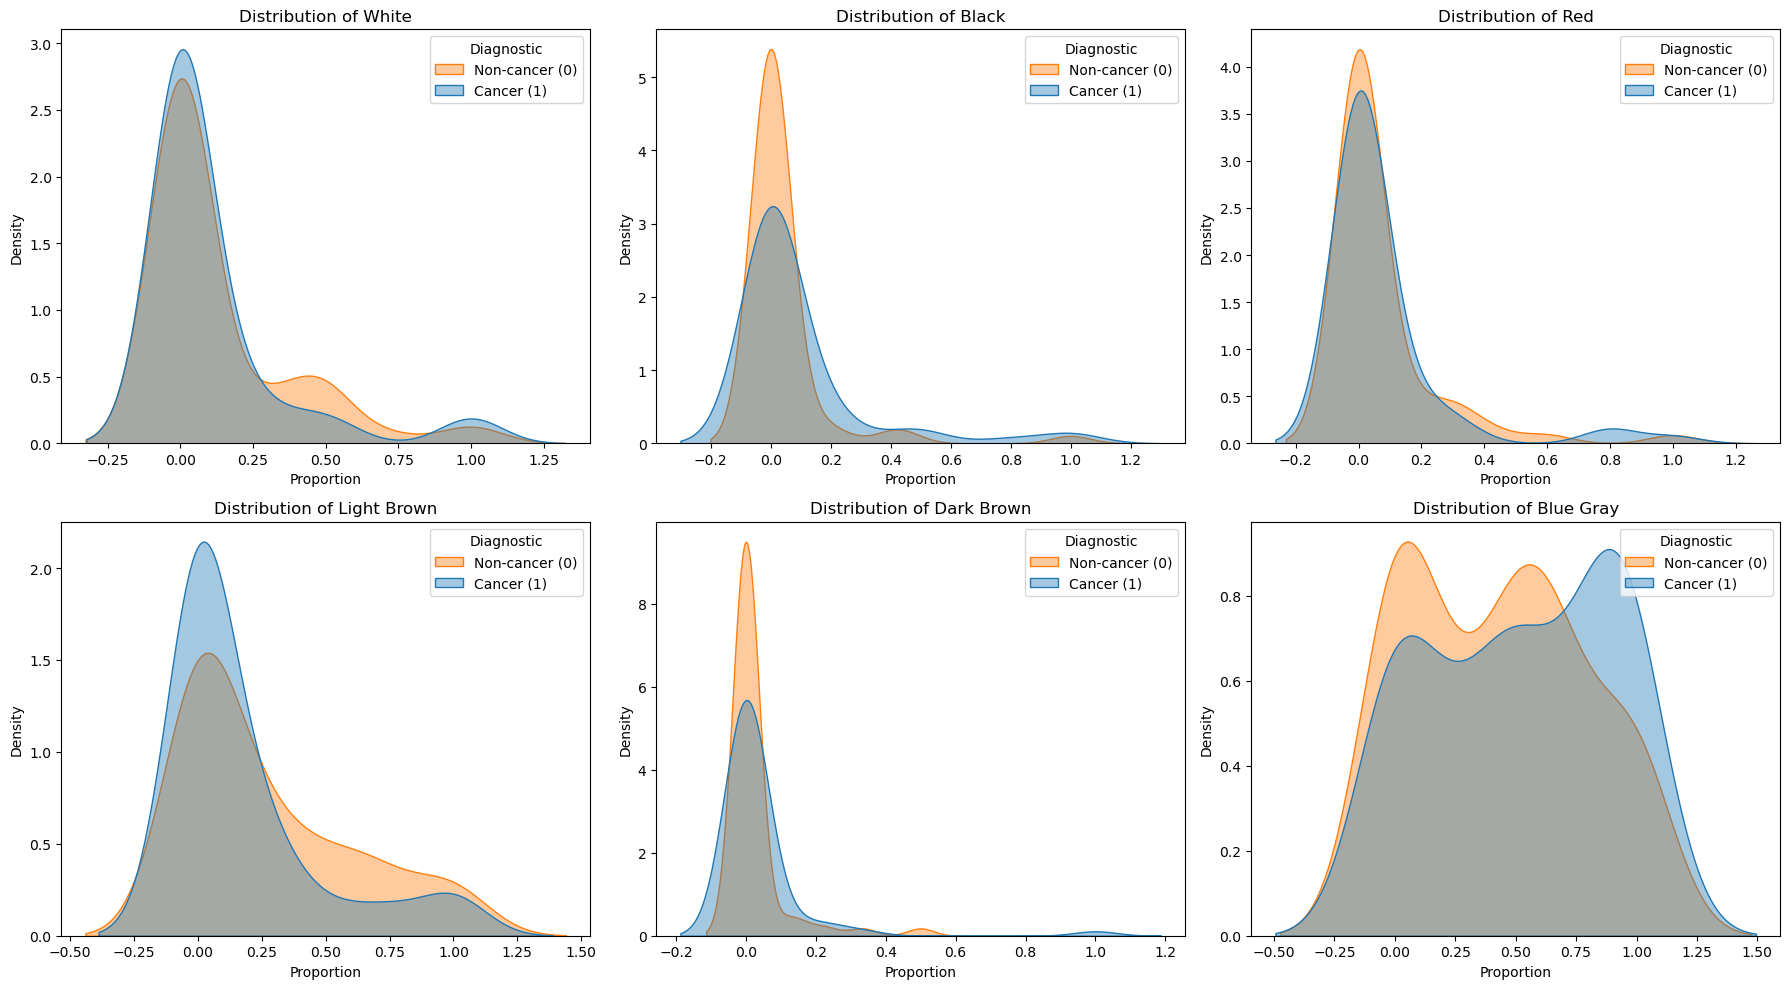

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of color feature names
color_features = ['white', 'black', 'red', 'light_brown', 'dark_brown', 'blue_gray']

# Set up the figure
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Plot each color feature
for i, color in enumerate(color_features):
    sns.kdeplot(data=data_better, x=color, hue='diagnostic', common_norm=False, fill=True, alpha=0.4, ax=axes[i])
    axes[i].set_title(f"Distribution of {color.replace('_', ' ').title()}")
    axes[i].set_xlabel('Proportion')
    axes[i].set_ylabel('Density')
    axes[i].legend(title='Diagnostic', labels=['Non-cancer (0)', 'Cancer (1)'])

plt.tight_layout()
plt.show()


We see some separability patterns, such as blue_gray, higher proportions of black and dark brown in canerous lesions. This is a good sign, meaning that a combination of all color proportions plus border and asymmetry values will probably give good predictions.

Trying out binary mask code for images